In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

# Data loading

In [17]:
file_path = './verified_pb.data'
data = pd.read_csv(file_path, sep='\t', header=None)

data

,0,1,2,3,4,5,6,7
0,1,1,1,IY,160.0,240.0,2280.0,2850.0
1,1,1,1,IY,186.0,280.0,2400.0,2790.0
2,1,1,2,IH,203.0,390.0,2030.0,2640.0
3,1,1,2,IH,192.0,310.0,1980.0,2550.0
4,1,1,3,EH,161.0,490.0,1870.0,2420.0
...,...,...,...,...,...,...,...,...
1515,3,76,8,UH,322.0,610.0,1550.0,3400.0
1516,3,76,9,UW,345.0,520.0,1250.0,3460.0
1517,3,76,9,UW,334.0,500.0,1140.0,3380.0
1518,3,76,10,ER,308.0,740.0,1850.0,2160.0


 # Data types, duplicated rows, missing values

In [18]:
print(data.dtypes)

duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
data_cleaned = data.drop_duplicates()
print(f"Number of rows after removing duplicates: {len(data_cleaned)}")


missing_values = data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


0      int64
1      int64
2      int64
3     object
4    float64
5    float64
6    float64
7    float64
dtype: object

Number of duplicate rows: 1
Number of rows after removing duplicates: 1519

Missing values in each column:
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


# Train, validation, test sets, one-hot-encoding, normalizing 

In [19]:
data = data.drop(columns=[3]) # this column does not provide additional information and its format is also problematic

data.columns = ['gender', 'speaker', 'phoneme', 'F0', 'F1', 'F2', 'F3']

X = data.drop(columns=['phoneme']) 
y = data['phoneme'] 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

data = pd.get_dummies(data, columns=['gender', 'speaker'], drop_first=True) # at catboost modell it is not necessary

scaler = StandardScaler() # at catboost modell it is not necessary
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
data

,phoneme,F0,F1,F2,F3,gender_2,gender_3,speaker_2,speaker_3,speaker_4,...,speaker_67,speaker_68,speaker_69,speaker_70,speaker_71,speaker_72,speaker_73,speaker_74,speaker_75,speaker_76
0,1,160.0,240.0,2280.0,2850.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,186.0,280.0,2400.0,2790.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,203.0,390.0,2030.0,2640.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2,192.0,310.0,1980.0,2550.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3,161.0,490.0,1870.0,2420.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,8,322.0,610.0,1550.0,3400.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1516,9,345.0,520.0,1250.0,3460.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1517,9,334.0,500.0,1140.0,3380.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1518,10,308.0,740.0,1850.0,2160.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True


# Simple catboost modell

Catboost is a machine learning algorithm that can handle categorical features without the need for explicit one-hot encoding. Furthermore, Catboost does not require the normalization of features, as tree-based algorithms are inherently insensitive to the scale of the variables.

In [21]:
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,  
                           depth=3, 
                           verbose=0)  

model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy}')

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Validation Accuracy: 0.875
Test Accuracy: 0.868421052631579


# Catboost modell optimization

In [67]:
param_grid = {
    'iterations': [200, 500, 1000, 1200],               # number of iterations
    'learning_rate': [0.001, 0.01, 0.1, 0.2],           # learning rate
    'depth': [3, 5, 8, 10],                             # depth
}

model = CatBoostClassifier(verbose=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best hyperparameters:', grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy:.2f}')

Best hyperparameters: {'depth': 5, 'iterations': 1000, 'learning_rate': 0.2}
Validation Accuracy: 0.91


# Results

In [22]:
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.2,  
                           depth=5,
                           verbose=0)  

model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy}')

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Validation Accuracy: 0.9078947368421053
Test Accuracy: 0.8947368421052632


# Can we reach better accuracy without column F0?

In [23]:
data = data.drop(['F0'], axis=1)

X = data.drop(columns=['phoneme']) 
y = data['phoneme'] 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [25]:
param_grid = {
    'iterations': [200, 500, 1000, 1200],               
    'learning_rate': [0.001, 0.01, 0.1, 0.2],           
    'depth': [3, 5, 8, 10],                             
}

model = CatBoostClassifier(verbose=0)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best hyperparameters:', grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy:.2f}')

Best hyperparameters: {'depth': 10, 'iterations': 1200, 'learning_rate': 0.2}
Validation Accuracy: 0.89


In [26]:
model = CatBoostClassifier(iterations=1200, 
                           learning_rate=0.2,  
                           depth=10,
                           verbose=0)  

model.fit(X_train, y_train)

y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print(f'Validation Accuracy: {accuracy}')

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy}')

Validation Accuracy: 0.8881578947368421
Test Accuracy: 0.9144736842105263


### Without column F0 we could reach a slightly better accuracy score on the test set

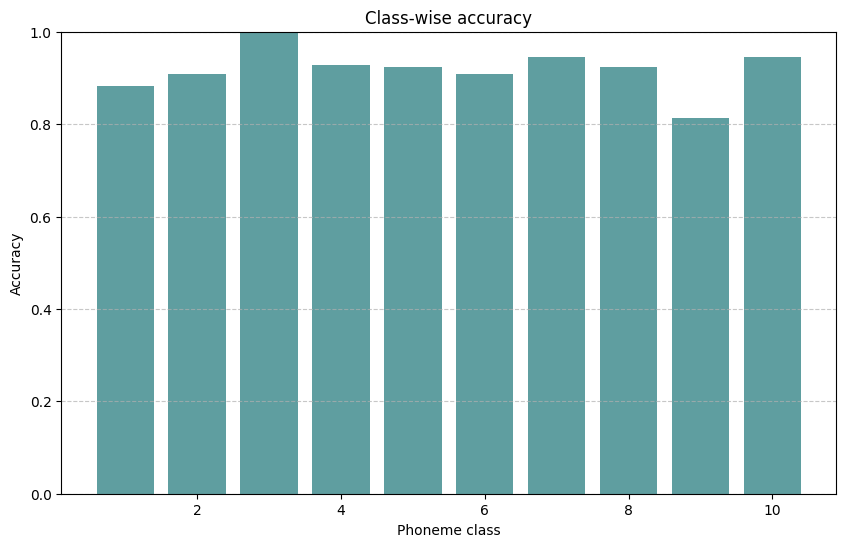

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.unique(y))

class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

class_labels = np.unique(y)
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='cadetblue')
plt.xlabel('Phoneme class')
plt.ylabel('Accuracy')
plt.title('Class-wise accuracy')
plt.xticks()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The chart shows the accuracy for each phoneme class, with accuracy values typically ranging between 0 and 1.
High accuracy for a class means the model predicts that class correctly most of the time. For example the model predicted correctly all of the records from class 3, but we got the worst score at class 9, which is ~ 0.8. Overall, it can be said that the model performs well on this data.

My help was in this project: ChatGPT, Google